In [5]:
IMAGE_NAME = "graph2" # 변경 ㄱㄴ
IMAGE_PATH = "./data/image/" + IMAGE_NAME + ".png" # 건들 ㄴㄴ
print("Data: "+IMAGE_PATH)

Data: ./data/image/graph2.png


## 이미지 크기 추출

In [6]:
import cv2

# 전역 변수
points_selected = []  # 선택된 좌표를 저장할 리스트
img_copy = None       # 원본 이미지의 복사본

# 마우스 콜백 함수
def select_points(event, x, y, flags, param):
    global points_selected, img_copy
    if event == cv2.EVENT_LBUTTONDOWN:
        if len(points_selected) < 2:
            points_selected.append((x, y))
            cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
        if len(points_selected) == 2:
            x1, y1 = points_selected[0]
            x2, y2 = points_selected[1]
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Save the result instead of displaying it

# 이미지 로드
image_path = IMAGE_PATH  # Replace with your image path
img = cv2.imread(image_path)

if img is None:
    print(f"Error: Could not load image at {image_path}.")
    exit()

img_copy = img.copy()

# GUI 창 열기 및 마우스 이벤트 연결
cv2.namedWindow("Image")  # Create a window
cv2.setMouseCallback("Image", select_points)

print("이미지에서 두 점을 클릭하여 영역을 선택하세요. (왼쪽 상단 -> 오른쪽 하단)")

# 두 점이 선택될 때까지 대기
while len(points_selected) < 2:
    cv2.imshow("Image", img_copy)
    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit if needed
        break

# 선택된 좌표 출력
if len(points_selected) == 2:
    (x1, y1), (x2, y2) = points_selected
    print(f"선택된 좌표: x1={x1}, y1={y1}, x2={x2}, y2={y2}")

cv2.destroyAllWindows()

이미지에서 두 점을 클릭하여 영역을 선택하세요. (왼쪽 상단 -> 오른쪽 하단)
선택된 좌표: x1=108, y1=9, x2=804, y2=326


## 그래프 추출

### 그래프 추출(무지개)

In [7]:
import cv2
import numpy as np
import json
import os

# 이미지 로드
image_path = IMAGE_PATH  # 경로를 실제 파일 경로로 수정
img = cv2.imread(image_path)

# 이미지 로드 확인
if img is None:
    print(f"Error: Could not load image at {image_path}. Check the file path or file existence.")
    exit()

# 이미지 크기
height, width = img.shape[:2]

# 사용자에게 x축과 y축 픽셀 범위 입력 받기
print(f"이미지 크기: 너비={width}, 높이={height}")
x_pixel_min = x1
x_pixel_max = x2
y_pixel_min = y1
y_pixel_max = y2

# 입력값 검증
if not (0 <= x_pixel_min < x_pixel_max <= width):
    print("Error: x_pixel_min과 x_pixel_max가 이미지 너비 내에 있어야 합니다.")
    exit()
if not (0 <= y_pixel_min < y_pixel_max <= height):
    print("Error: y_pixel_min과 y_pixel_max가 이미지 높이 내에 있어야 합니다.")
    exit()

# x축 실제 값 범위 (250nm ~ 900nm)
x_real_min, x_real_max = int(input("x값 시작: ")), int(input("x값 끝 시작: "))

# y축 실제 값 범위 (0% ~ 100%)
y_real_min, y_real_max = int(input("y값 시작: ")), int(input("y값 끝 시작: "))

# 간격 설정 (이미지 x축 길이의 100분의 1)
interval = (x_pixel_max - x_pixel_min) // 100  # x축 분석 범위의 1/100로 설정
if interval < 1:
    interval = 1  # 간격이 1픽셀 미만이 되지 않도록 보정

# 픽셀과 실제 값 간 변환 함수
def pixel_to_real(x_pixel, y_pixel):
    x_real = x_real_min + (x_pixel - x_pixel_min) * (x_real_max - x_real_min) / (x_pixel_max - x_pixel_min)
    y_real = y_real_max - (y_pixel - y_pixel_min) * (y_real_max - y_real_min) / (y_pixel_max - y_pixel_min)
    return x_real, y_real

def real_to_pixel(x_real):
    return x_pixel_min + (x_real - x_real_min) * (x_pixel_max - x_pixel_min) / (x_real_max - x_real_min)

# 픽셀 단위로 x 좌표 설정 (interval을 픽셀 단위로 사용)
x_pixel_points = np.arange(x_pixel_min, x_pixel_max + 1, interval).astype(int)

# 색상별 HSV 범위 (빨강, 주황, 노랑, 초록, 파랑, 남색, 보라)
color_ranges = {
    "red": ([0, 120, 70], [10, 255, 255], [170, 120, 70], [180, 255, 255]),
    "orange": ([10, 100, 100], [25, 255, 255], None, None),
    "yellow": ([25, 100, 100], [35, 255, 255], None, None),
    "green": ([40, 100, 100], [80, 255, 255], None, None),
    "blue": ([100, 100, 100], [130, 255, 255], None, None),
    "navy": ([130, 100, 100], [140, 255, 255], None, None),
    "purple": ([140, 100, 100], [160, 255, 255], None, None),
    # "black": ([0, 0, 0], [180, 50, 50], None, None)  # 검정색 추가
}

# 모든 색상에 대해 처리
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)
json_dir = os.path.join(results_dir, "json")
image_dir = os.path.join(results_dir, "image")
os.makedirs(json_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)

for color_name, (lower1, upper1, lower2, upper2) in color_ranges.items():
    # 원본 이미지 복사본 생성 (각 색상에 대해 독립적인 이미지 사용)
    img_color = img.copy()

    # HSV 변환
    hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)

    # 마스크 생성
    if lower2 is not None and upper2 is not None:
        mask1 = cv2.inRange(hsv, np.array(lower1), np.array(upper1))
        mask2 = cv2.inRange(hsv, np.array(lower2), np.array(upper2))
        mask = mask1 + mask2
    else:
        mask = cv2.inRange(hsv, np.array(lower1), np.array(upper1))

    # 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 결과 저장 리스트
    points = []

    # 곡선 위에 X 마커 추가 및 좌표 저장
    for contour in contours:
        for x_pixel in x_pixel_points:
            y_coords = [point[0][1] for point in contour if abs(point[0][0] - x_pixel) < 5]
            if y_coords:
                y_pixel = int(np.mean(y_coords))
                # 해당 색상에만 마커 그리기
                cv2.drawMarker(img_color, (x_pixel, y_pixel), (0, 255, 0), 
                              markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2)
                x_real, y_real = pixel_to_real(x_pixel, y_pixel)
                points.append({"x": x_real, "y": y_real})

    # 데이터가 존재할 경우에만 저장
    if points:
        json_save_path = os.path.join(json_dir, f"{IMAGE_NAME}/extracted_points({color_name}).json")
        os.makedirs(os.path.dirname(json_save_path), exist_ok=True)
        with open(json_save_path, "w") as f:
            json.dump(points, f, indent=4)
        print(f"json file saved at {json_save_path}")

        image_save_path = os.path.join(image_dir, f"{IMAGE_NAME}/graph_with_x_markers({color_name}).png")
        os.makedirs(os.path.dirname(image_save_path), exist_ok=True)
        cv2.imwrite(image_save_path, img_color)
        print(f"image file saved at {image_save_path}")
    else:
        print(f"No graph detected for color: {color_name}, skipping file creation.")

이미지 크기: 너비=845, 높이=388
json file saved at ./results\json\graph2/extracted_points(red).json
image file saved at ./results\image\graph2/graph_with_x_markers(red).png
json file saved at ./results\json\graph2/extracted_points(orange).json
image file saved at ./results\image\graph2/graph_with_x_markers(orange).png
No graph detected for color: yellow, skipping file creation.
json file saved at ./results\json\graph2/extracted_points(green).json
image file saved at ./results\image\graph2/graph_with_x_markers(green).png
json file saved at ./results\json\graph2/extracted_points(blue).json
image file saved at ./results\image\graph2/graph_with_x_markers(blue).png
No graph detected for color: navy, skipping file creation.
No graph detected for color: purple, skipping file creation.


## 추출한 이미지 시각화

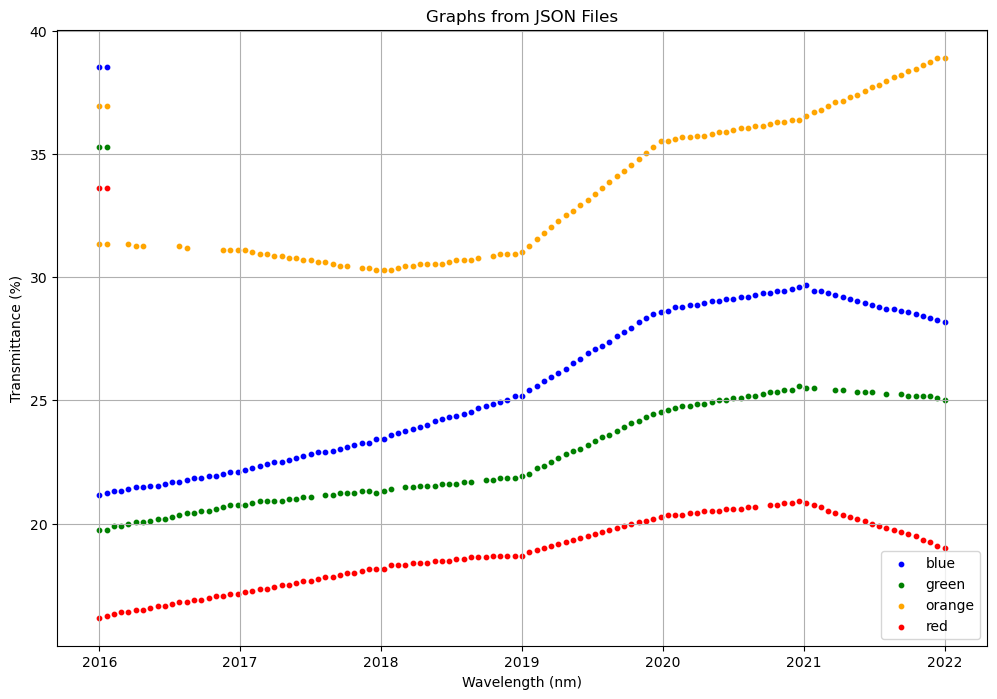

In [8]:
import matplotlib.pyplot as plt
import json
import os

# 디렉토리 경로 설정
directory_path = "./results/json/"+IMAGE_NAME

# 모든 JSON 파일 목록 가져오기
json_files = [f for f in os.listdir(directory_path) if f.endswith('.json')]

# 색상 매핑 (JSON 파일 이름에서 추출한 색상에 따라 매핑)
color_mapping = {
    "red": "red",
    "orange": "orange",
    "yellow": "yellow",
    "green": "green",
    "blue": "blue",
    "navy": "navy",
    "purple": "purple",
    "black": "black"
}

# 그래프 그리기 준비
plt.figure(figsize=(12, 8))  # 그래프 크기 설정

# 각 JSON 파일 처리
for json_file in json_files:
    file_path = os.path.join(directory_path, json_file)
    
    # JSON 파일에서 색상 이름 추출 (예: "extracted_points(red).json" -> "red")
    color_name = json_file.split("(")[1].split(")")[0]
    
    # 색상 유효성 확인
    if color_name not in color_mapping:
        print(f"Warning: Unknown color '{color_name}' in {json_file}, using default color.")
        color = "gray"  # 기본 색상
    else:
        color = color_mapping[color_name]
    
    # JSON 파일에서 데이터 불러오기
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # x, y 좌표를 리스트로 추출 (문자열을 float로 변환)
    x_values = [float(point["x"]) for point in data]
    y_values = [float(point["y"]) for point in data]
    
    # 그래프 그리기
    plt.scatter(x_values, y_values, color=color, s=10, label=color_name)  # 데이터 포인트 표시

# 그래프 꾸미기
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance (%)')
plt.title('Graphs from JSON Files')
plt.legend()  # 범례 추가
plt.grid(True)

# 그래프 표시
plt.show()